In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time

import requests
from datetime import datetime

from windrose import WindroseAxes

from ipypb import track

In [39]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)

In [6]:
class Wrapper():
    dt_2_unix = lambda self, datetime: int(datetime.timestamp())
    timestamp_2_unix = lambda self, timestamp: (timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') 

    def construct_url(self, latitude, longitude, time=None, query={}):
        ## Preparing parameters
        default_params = {
            'units' : 'si',
            'lang' : 'en',
            'extend' : 'hourly',
        }
        
        default_params.update(query)
        
        ## Constructing main url
        url_root = 'https://api.darksky.net/forecast'
        url = f'{url_root}/{self.API_key}/{latitude},{longitude}'
        
        ## Handling time 
        if time:
            if isinstance(time, datetime):
                time = self.dt_2_unix(time)
                
            if isinstance(time, pd.Timestamp):
                time = self.timestamp_2_unix(time)
            
            url += f',{time}'
                
        ## Adding query parameters
        query_params = '?'

        for query_param, param_value in default_params.items():
            query_params += f'{query_param}={param_value}&'

        query_url = url + query_params[:-1] # We dont want the last '&'

        return query_url
    
    def url_2_df(self, query_url):
        r = requests.get(query_url)
        r_json = r.json()

        df = pd.DataFrame(r_json['hourly']['data'])
        df['time'] = df['time'].apply(datetime.fromtimestamp)

        return df
    
    def lat_lon_dt_2_df(self, latitude, longitude, time=None, query={}):
        query_url = self.construct_url(latitude, longitude, time=time, query=query)
        df = self.url_2_df(query_url)
        
        return df
        
    def __init__(self, API_key):
        self.API_key = API_key

In [14]:
API_key = '' #add key

dt = pd.to_datetime('2018-01-01')
latitude = '51.507351' 
longitude = '-0.127758'

darksky = Wrapper(API_key)
df = darksky.lat_lon_dt_2_df(latitude, longitude, time=dt)

df.head()

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType
0,2018-01-01 01:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,7.54,4.77,3.66,0.76,997.3,4.41,7.76,252,0.83,0,10.003,NaN
1,2018-01-01 02:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,7.32,4.68,3.59,0.77,998.3,4.06,6.42,248,0.40,0,10.003,NaN
2,2018-01-01 03:00:00,Clear,clear-night,0.0,0.0,6.56,4.18,3.20,0.79,999.5,3.32,5.94,250,0.17,0,10.003,NaN
3,2018-01-01 04:00:00,Clear,clear-night,0.0,0.0,6.36,3.91,2.67,0.77,999.6,3.35,5.71,243,0.07,0,10.003,NaN
4,2018-01-01 05:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,6.08,3.89,2.80,0.80,999.7,2.87,5.88,230,0.64,0,10.003,NaN


In [15]:
start_date = '2018-09-20 11:00:00'
end_date = '2020-01-13 00:00:00'

dt_rng = pd.date_range(start_date, end_date, freq='D')

dt_rng

DatetimeIndex(['2018-09-20 11:00:00', '2018-09-21 11:00:00',
               '2018-09-22 11:00:00', '2018-09-23 11:00:00',
               '2018-09-24 11:00:00', '2018-09-25 11:00:00',
               '2018-09-26 11:00:00', '2018-09-27 11:00:00',
               '2018-09-28 11:00:00', '2018-09-29 11:00:00',
               ...
               '2020-01-03 11:00:00', '2020-01-04 11:00:00',
               '2020-01-05 11:00:00', '2020-01-06 11:00:00',
               '2020-01-07 11:00:00', '2020-01-08 11:00:00',
               '2020-01-09 11:00:00', '2020-01-10 11:00:00',
               '2020-01-11 11:00:00', '2020-01-12 11:00:00'],
              dtype='datetime64[ns]', length=480, freq='D')

In [16]:
df = pd.DataFrame()

for dt in track(dt_rng):
    df_dt = darksky.lat_lon_dt_2_df(latitude, longitude, time=dt)
    df = df.append(df_dt, sort=False)
    
    time.sleep(1) # Significantly reduces the number of times the request is rejected
    
df.head(5)

 [████████████████████████████████████████████████████████████] 480/480 [11:56<00:02, 1.49s/it]

,time,summary,icon,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
0,2018-09-20 01:00:00,Overcast,cloudy,0.0134,0.03,rain,18.46,18.46,14.88,0.80,1014.5,5.76,11.21,228,0.93,0,16.093,291.0,NaN
1,2018-09-20 02:00:00,Overcast,cloudy,0.0120,0.03,rain,18.05,18.05,14.76,0.81,1014.5,5.36,10.40,214,0.89,0,16.093,292.1,NaN
2,2018-09-20 03:00:00,Overcast,cloudy,0.0129,0.05,rain,18.07,18.07,14.90,0.82,1014.3,5.58,10.89,214,0.90,0,16.093,292.1,NaN
3,2018-09-20 04:00:00,Overcast,cloudy,0.0169,0.05,rain,18.19,18.21,15.07,0.82,1013.9,5.99,11.78,216,0.93,0,16.093,291.9,NaN
4,2018-09-20 05:00:00,Overcast,cloudy,0.0201,0.06,rain,18.31,18.34,15.20,0.82,1013.5,6.31,12.43,218,0.95,0,16.093,291.9,NaN


In [17]:
df.tail(5)

,time,summary,icon,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
19,2020-01-12 20:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,NaN,8.39,6.58,5.00,0.79,1021.0,3.01,8.28,232,0.52,0,16.093,320.5,NaN
20,2020-01-12 21:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,NaN,8.06,6.10,4.75,0.80,1020.3,3.13,8.59,229,0.47,0,16.093,329.2,NaN
21,2020-01-12 22:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,NaN,7.78,5.72,4.46,0.80,1020.2,3.21,9.01,227,0.34,0,16.093,337.9,NaN
22,2020-01-12 23:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,NaN,7.53,5.61,4.30,0.80,1020.2,2.90,9.50,224,0.51,0,16.093,346.9,NaN
23,2020-01-13 00:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,NaN,7.32,5.46,4.08,0.80,1020.4,2.76,10.10,219,0.72,0,16.093,355.9,NaN


In [18]:
save_df = True

if save_df == True:
    df.to_csv('darksky_weather_full.csv', index=False)

In [56]:
read_df = True

if read_df == True:
    df = pd.read_csv('darksky_weather_full.csv')
    df['time'] = pd.to_datetime(df['time'])
    
#df_focus = df[['time','temperature', 'windBearing', 'windSpeed', 'ozone', 'precipIntensity', 'pressure']]

df_focus = df[['time', 'temperature', 'windBearing', 'windSpeed', 'ozone', 'pressure']]

df_focus.head()

,time,temperature,windBearing,windSpeed,ozone,pressure
0,2018-09-20 01:00:00,18.46,228,5.76,291.0,1014.5
1,2018-09-20 02:00:00,18.05,214,5.36,292.1,1014.5
2,2018-09-20 03:00:00,18.07,214,5.58,292.1,1014.3
3,2018-09-20 04:00:00,18.19,216,5.99,291.9,1013.9
4,2018-09-20 05:00:00,18.31,218,6.31,291.9,1013.5


In [57]:
save_df = True

if save_df == True:
    df_focus.to_csv('darksky_weather_focus.csv', index=False)

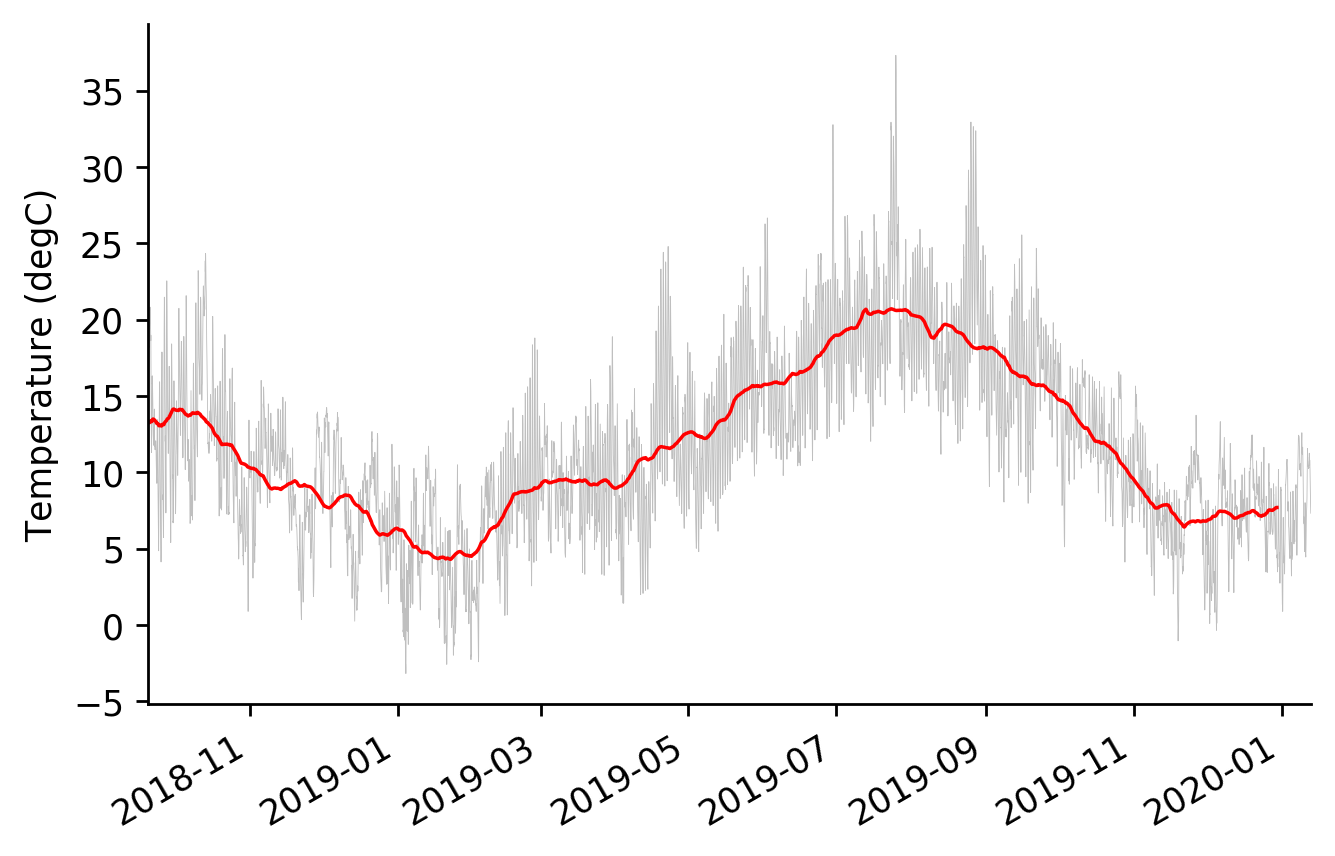

In [31]:
rolling_days = 28

s_rolling_temp = (df_focus
                  ['temperature']
                  .rolling(f'{rolling_days}D')
                  .mean()
                  .shift(-rolling_days//2, freq='D')
                 )

## Plotting
fig, ax = plt.subplots(dpi=250)

df_focus['temperature'].plot(ax=ax, color='k', linewidth=0.25, alpha=0.25)
s_rolling_temp.plot(ax=ax, color='red', linewidth=1)

ax.set_xlabel('')
ax.set_ylabel('Temperature (degC)')
ax.set_xlim(df_focus.index[0], df_focus.index[-1])

hide_spines(ax)


ValueError: unknown locale: UTF-8

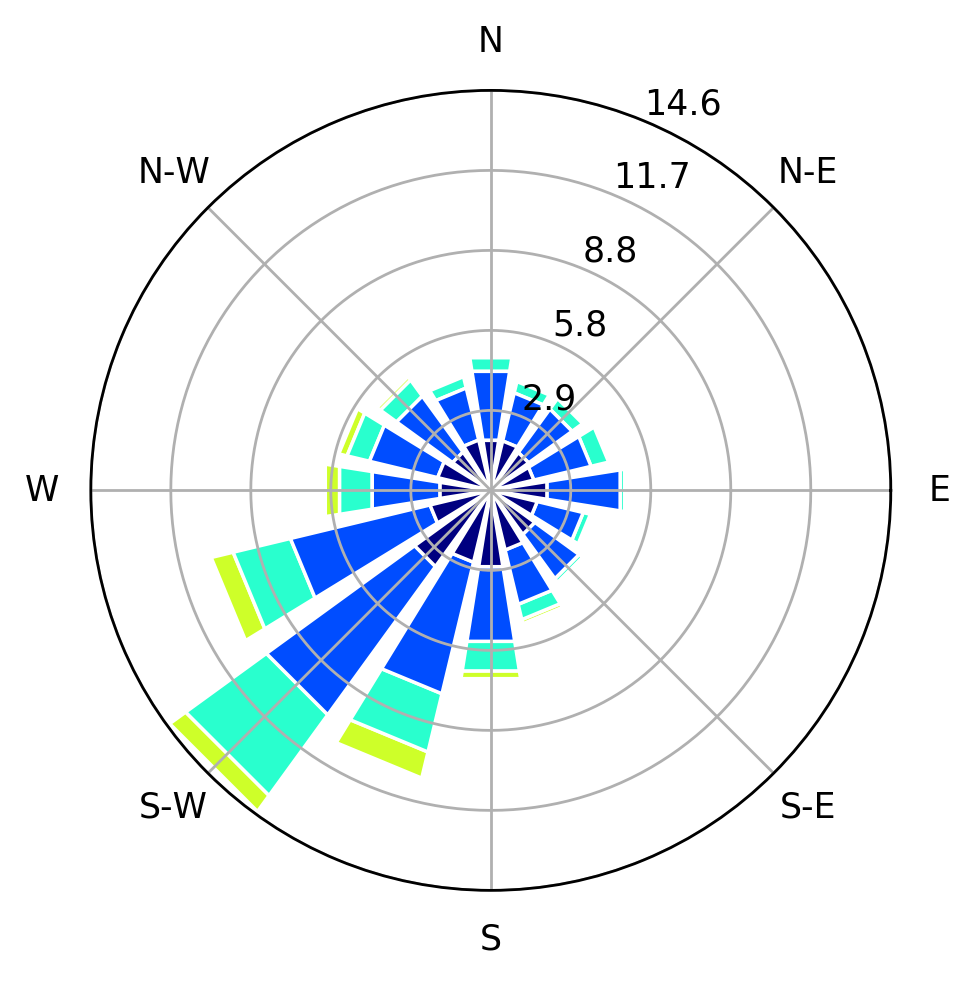

In [44]:
fig = plt.figure(dpi=250)
ax = WindroseAxes.from_ax(fig=fig)

ax.bar(df_focus['windBearing'], df_focus['windSpeed'], normed=True, opening=0.8, edgecolor='white')

ax.legend(frameon=False, bbox_to_anchor=(0.95, 0.95), 
          title='Wind Speeds', prop={'size': 6}, title_fontsize=8)

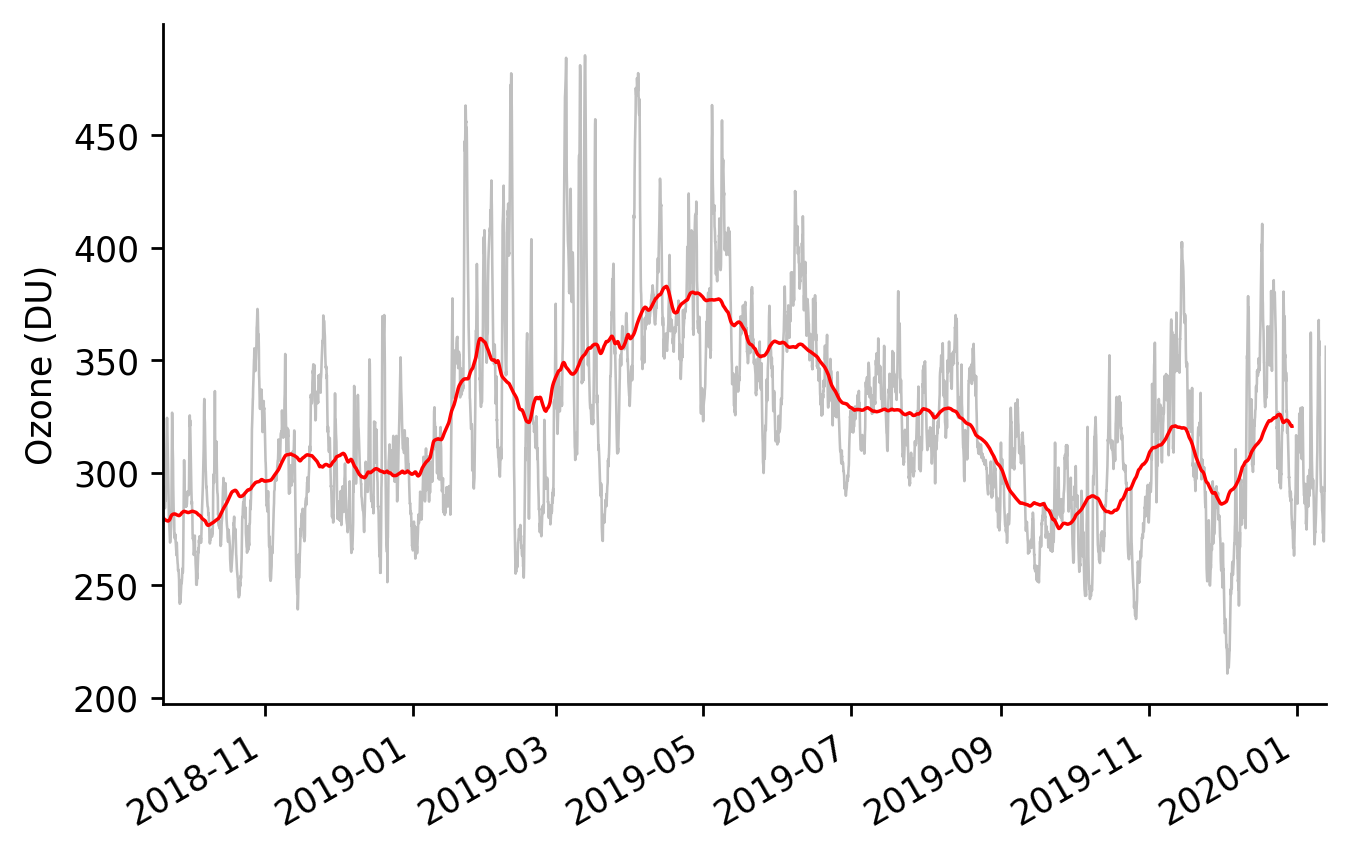

In [45]:
rolling_days = 28

s_rolling_ozone = (df_focus
                  ['ozone']
                  .rolling(f'{rolling_days}D')
                  .mean()
                  .shift(-rolling_days//2, freq='D')
                 )

## Plotting
fig, ax = plt.subplots(dpi=250)

df_focus['ozone'].plot(ax=ax, color='k', linewidth=0.75, alpha=0.25)
s_rolling_ozone.plot(ax=ax, color='red', linewidth=1)

ax.set_xlabel('')
ax.set_ylabel('Ozone (DU)')
ax.set_xlim(df_focus.index[0], df_focus.index[-1])

hide_spines(ax)

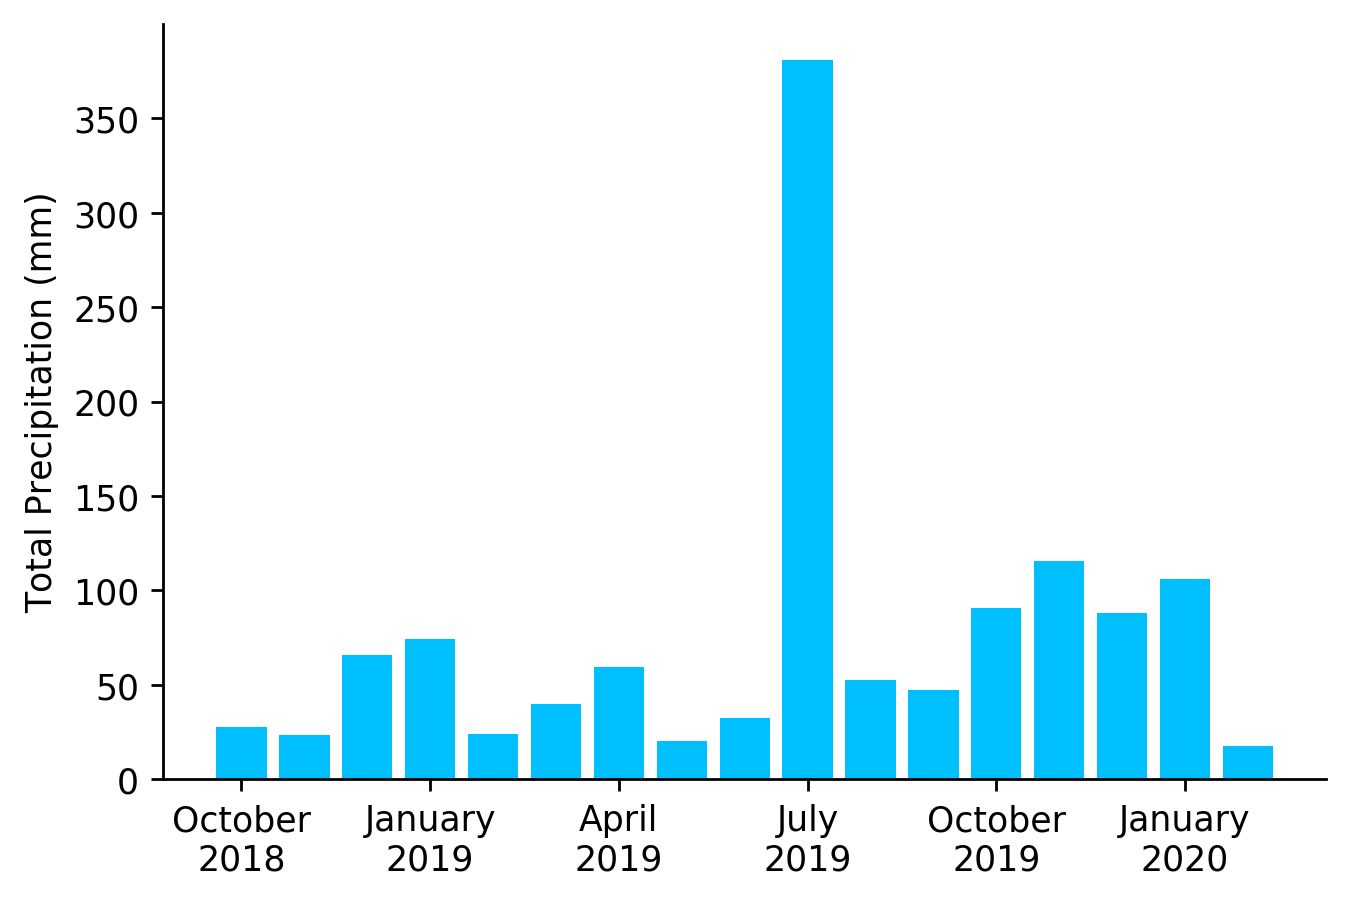

In [46]:
s_monthly_precip = (df_focus
                    ['precipIntensity']
                    .resample('M')
                    .sum()
                    .shift(15, 'D')
                   )

dates = s_monthly_precip.index
precip_mm = s_monthly_precip.values

dt_idxs = list(range(dates.shape[0]))
labels = [f'{x[0]}\n{x[1]}' for x in list(zip(dates.month_name(), dates.year.astype(str)))]

## Plotting
fig, ax = plt.subplots(dpi=250)

ax.bar(dt_idxs, precip_mm, color='deepskyblue')

ax.set_xticks(dt_idxs[::3])
ax.set_xticklabels(labels[::3])
ax.set_ylabel('Total Precipitation (mm)')

hide_spines(ax)

In [47]:
#rain data seems a bit strange....